# Neural Networks with Pytorch

In this module we'll explore the basics of neural networks using commercial tools.

In [1]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch.nn
import torch.optim
import torch.utils.data

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  !ls /content/gdrive/My\ Drive/Colab\ Notebooks/Colab152/utils/*.py
  sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Colab152/utils')
else:
  sys.path.append('../utils')

#### Building Block

The internal structure of a NN is naturally described by a computation graph that connects simple building blocks. The basic building-block unit is a function of $D$ input features $x_i$,
$$
f(\mathbf{x}) = \phi\left(\mathbf{x}\cdot\mathbf{w} + b\right)
$$
with $D+1$ parameters consisting of $D$ **weights** $w_i$ and a single **bias** $b$.

The recipe for obtaining the output value is then:
 - propagate each input value $x_i$ with a strength $w_i$,
 - sum the values $x_i w_i$,
 - apply the activation $\phi$.

Note that this building block is mostly linear, except for the **activation function** $\phi(s)$. This allows us to implicitly work in a higher dimensional space where non-linear structure in data is easier to model.

The building-block equation is straightfoward to implement as code:

In [4]:
def nn_unit(x, w, b, phi):
    return phi(np.dot(x, w) + b)

Note that we pass in phi as an argument, so this is completely generic.

In [5]:
nn_unit(x=[0, 1, -1], w=[1, 2, 3], b=-1, phi=np.tanh)

-0.9640275800758169

We can define other common activation functions:

In [6]:
relu = lambda s: np.maximum(0, s)
elu = lambda s: np.maximum(0, s) + np.minimum(0, np.expm1(s)) # expm1(s) = exp(s) - 1
softplus = lambda s: np.log(1 + np.exp(s))
sigmoid = lambda s: 1 / (1 + np.exp(-s)) # also known as the "logistic function"
tanh = lambda s: np.tanh(s)
softsign = lambda s: s / (np.abs(s) + 1)

#### Network Layer

What happens if we replace the vectors $\mathbf{x}$ and $\mathbf{w}$ above with matrices?
$$
F(X) = \phi\left( X W + \mathbf{b}\right)
$$
If $X$ has shape $(N, D)$ and holds $N$ samples of $D$ features, then $W$ must have shape $(D, M)$ so $F(X)$ converts the $D$ input features into $M$ output features for each sample. We say that $F$ represents a linear network **layer** with $D$ input nodes and $M$ output nodes. Note that the bias is now a vector of $M$ bias values, one for each output value.

We cannot really add a vector $\mathbf{b}$ to the matrix $X W$ but we are using the "broadcasting" convention that this means add the same vector to each row (sample) of $X W$.  We also cannot apply $\phi(s)$ to a matrix, but we are using the "elementwise" convention that this means apply $\phi$ separately to each element of the matrix.

To connect this matrix version with our earlier vector version, notice that $F(X)$ transforms a single input sample $\mathbf{x}_i$ (row of $X$) into $M$ different outputs, $f_m(\mathbf{x}_i)$ each with their own weight vector and bias value:
$$
f_m(\mathbf{x}_i) = \phi\left(\mathbf{x}_i\cdot \mathbf{w}_m + b_m\right) \; ,
$$
where $\mathbf{w}_m$ is the $m$-th column of $W$ and $b_m$ is the $m$-th element of $\mathbf{b}$.

The `nn_unit` function we defined above already implements a layer if we pass it matrices $X$ and $W$ and a vector $\mathbf{b}$. For example:

In [7]:
nn_unit(x=[[1., 0.5], [-1, 1]], w=[[1, -1, 1], [2, 0, 1]], b=[-1, 1, 0], phi=sigmoid)

array([[0.73105858, 0.5       , 0.81757448],
       [0.5       , 0.88079708, 0.5       ]])

A layer with $n_{in}$ inputs and $n_{out}$ outputs has a total of $(n_{in} + 1) n_{out}$ parameters. These can add up quickly when building useful networks!

#### Network Graph

Finally, we can build a simple **fully connected graph** by stacking layers horizontally, which corresponds to nested calls of each layer's function. For example, with 3 layers computed by $F$, $G$, $H$ stacked (left to right), the overall graph computation is:
$$
N(X) = H\left(G\left(F(X)\right)\right) \; ,
$$

Nodes between the input (leftmost) and output (rightmost) nodes are known as **hidden nodes**.

The corresponding code for arbitrary layers is:

In [8]:
def nn_graph(X, *layers):
    for W, b, phi in layers:
        X = nn_unit(X, W, b, phi)
    return X

For example, here is a three-layer network with the same architecture as the graph above. Note how the output dimension of one layer must match the input dimension of the next layer.

In [9]:
nn_graph([1, 2, 3, 4, 5, 6, 7, 8],
    ([
        [11, 12, 13, 14],
        [21, 22, 23, 24],
        [31, 32, 33, 34],
        [41, 42, 43, 44],
        [51, 52, 53, 54],
        [61, 62, 63, 64],
        [71, 72, 73, 74],
        [81, 82, 83, 84],
    ], [1, 2, 3, 4], tanh),    # LYR1: n_in=8, n_out=4
    ([
        [11, 12, 13],
        [21, 22, 23],
        [31, 32, 33],
        [41, 42, 43],
    ], [1, 2, 3], relu),       # LYR2: n_in=4, n_out=3
    ([
        [11, 12],
        [21, 22],
        [31, 32],
    ], [1, 2], sigmoid)        # LYR3: n_in=3, n_out=4
)

array([1., 1.])

The weight and bias values are chosen to make the tensors easier to read, but would not make sense for a real network. As a result, the final output of `[1., 1.]` is not surprising given how the sigmoid activation saturates for input outside a narrow range.

### Data Flow Perspective

The diagram below show the tensors flowing forward (left to right) in a typical fully connected graph. The main flow consists of $N$ input samples flowing from $X_0$ to $X_4$ with a number of features that varies between layers:
$$
X_{n+1} = \phi\left( X_n\cdot W_{n+1} + \mathbf{b}_{n+1}\right) \; .
$$

The computation of each layer's output is parameterized by the weight and bias tensors shown: note how their shapes are determined by the number of input and output features for each layer. The parameter tensors are usually randomly initialized (more on this soon) so only the input $X_0$ and target $Y$ are needed to drive the calculation (and so must be copied to GPU memory when using hardware acceleration).

The final output $X_4$ is compared with the target values $Y$ to calculate a "loss" $\ell(X_4, Y)$ that decreases as $X_4$ becomes more similar to $Y$ (more on this soon).

![forward flow](https://raw.githubusercontent.com/dkirkby/MachineLearningStatistics/3aa7385e1fd0b1572013bdf1f1c823806b744b2d/notebooks/img/NeuralNetworks/forward_flow.png) 

The diagram below shows the gradient (partial derivative) tensors flowing backwards ("backpropagation") through the same graph using the chain rule:
$$
\frac{\partial \ell}{\partial X_n} = \frac{\partial \ell}{\partial X_{n+1}} \frac{\partial X_{n+1}}{\partial X_n}
\quad, \quad
\frac{\partial \ell}{\partial W_{n+1}} = \frac{\partial \ell}{\partial X_{n+1}} \frac{\partial X_{n+1}}{\partial W_{n+1}} \; .
$$

![backward flow](https://raw.githubusercontent.com/dkirkby/MachineLearningStatistics/3aa7385e1fd0b1572013bdf1f1c823806b744b2d/notebooks/img/NeuralNetworks/backward_flow.png)

Note that these gradient tensors are just numbers, not functions. All of these tensors occupy the (limited) GPU memory when using hardware acceleration but, in most applications, only the final output and the parameter gradients are stored (with 32-bit floating point precision).

When working with large datasets, the $N$ input samples are usually broken up into fixed-size randomly subsampled "minibatches". Optimiztion with the resulting parameter gradients leads to the "stochastic gradient descent" (SGD) algorithm.

### PyTorch Primer

A fully connected network can be created with a few lines in PyTorch:

In [10]:
torch.manual_seed(123)

net = torch.nn.Sequential(
    torch.nn.Linear(8, 4), #0
    torch.nn.ReLU(),    #1
    torch.nn.Linear(4, 3), #2
    torch.nn.ReLU(),    #3
    torch.nn.Linear(3, 2)  #4
)

As each `Linear` layer is created, its weight and bias tensors are automatically initialized with random values, so we initially set the torch random seed for reproducible results.

This construction breaks each layer into separate linear and activation "modules". Each module can be accessed via its index (0-4 in this example):

In [11]:
print(net)

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
)


In [12]:
net[2].weight

Parameter containing:
tensor([[-0.4228, -0.1435, -0.3521,  0.0331],
        [-0.0934, -0.2682, -0.0455,  0.4737],
        [-0.0394,  0.0159, -0.0780,  0.0786]], requires_grad=True)

In [13]:
net[4].bias

Parameter containing:
tensor([0.4928, 0.0345], requires_grad=True)

To run our network in the forward direction, we need some data with the expected number of features ($D=8$ in this example):


In [14]:
N = 100
D = net[0].in_features
Xin = torch.randn(N, D)
Xout = net(Xin)

The intermediate tensors ($X_1$, $\partial\ell/\partial X_1$, ...) shown in the data flow diagrams above are usually not preserved, but can be useful to help understand how a network is performing and diagnose problems. To cache these intermediate tensors, use:

In [35]:
import torchutils
torchutils.trace(net)

In [16]:
Xout = net(Xin)

Each submodule now has `input` and `output` attributes:

In [17]:
torch.equal(Xin, net[0].input)

True

In [18]:
torch.equal(net[0].output, net[1].input)

True

Use the `verbose` option to watch the flow of tensors through the network:

In [19]:
torchutils.trace(net, verbose=True)
Xout = net(Xin)

0: IN (100, 8) OUT (100, 4)
1: IN (100, 4) OUT (100, 4)
2: IN (100, 4) OUT (100, 3)
3: IN (100, 3) OUT (100, 3)
4: IN (100, 3) OUT (100, 2)


To complete the computational graph we need to calculate a (scalar) loss, for example:

In [20]:
loss = torch.mean(Xout ** 2)
print(loss)

tensor(0.1996, grad_fn=<MeanBackward0>)


We can now back propagate gradients of this loss through the network:

In [21]:
loss.backward()

4: GRAD (100, 2)
3: GRAD (100, 3)
2: GRAD (100, 3)
1: GRAD (100, 4)
0: GRAD (100, 4)


The gradients of each layer's parameters are now computed and stored, ready to "learn" better parameters through (stochastic) gradient descent (or one of its variants):

In [22]:
net[0].bias.grad

tensor([-0.0285, -0.0276, -0.0335,  0.0646])

Using `torchutils.trace` we have also captured the gradients of the loss with respect to each module's outputs $\partial\ell /\partial X_n$:

In [23]:
net[0].output.size(), net[0].grad.size()

(torch.Size([100, 4]), torch.Size([100, 4]))

These gradients can be useful to study since learning of all upstream parameters effectively stops when they become vanishly small (since they multiply those parameter gradients via the chain rule).

### Loss Functions

In order discover a good set of parameters using optimization, we need to specify a loss function to optimize.

The loss function $\ell(X_\text{out}, Y_\text{tgt})$ compares the actual network output $X_\text{out}$ with a corresponding target value $Y_\text{tgt}$ and approaches some minimum value as their agreement improves.

A loss function must be scalar valued since we need a single gradient for each parameter to implement gradient descent,
$$
\theta \rightarrow \theta - \eta\,\frac{\partial\ell}{\partial\theta} \; .
$$
Note that the loss normalization is degenerate with the learning rate $\eta$.

Our choice of loss function is primarily driven by the type of problem we are solving: regression or classification. We introduce the most obvious choices below but there are lots of reasonable variations (see [here](https://pytorch.org/docs/stable/nn.html#id51) for the complete PyTorch list).

#### Regression Loss

For regression, the $L_2$ norm is a popular choice,
$$
L_2 = \frac{1}{2}\, \left|
X_\text{out} - Y_\text{tgt}\right|^2 \; .
$$
Optimizing the $L_2$ norm is equivalent to finding the maximum-likelihood (ML) point estimate for the network parameters (weights and biases) if we assume that the uncertainties in $Y_\text{tgt}$ are "homoscedastic" (drawn from the same Gaussian distribution).

In PyTorch, the $L_2$ norm is implemented as [torch.nn.MSELoss](https://pytorch.org/docs/stable/nn.html#mseloss):

In [24]:
Y = torch.zeros_like(Xout)
loss = torch.nn.MSELoss()(Xout, Y)

In case you actually have a reasonable estimate $\sigma_Y^i$ of the $i$-th sample's target uncertainty, a better loss function is the $\chi^2$ statistic:
$$
\chi^2 = \sum_{i=1}^N\, \left( \frac{X_\text{out}^i - Y_\text{tgt}^i}{\sigma_Y^i}\right)^2 \; .
$$

#### Binary Classification Loss

For binary classification problems, the L2 norm can also be used but the binary [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the target and output probability distributions is often a better choice:
$$
\text{BCE} \equiv -\sum_{i=1}^N\, \left[
Y_{tgt}^i \log \phi_S(X_\text{out}^i) + (1 - Y_\text{tgt}^i) \log (1 - \phi_S(X_\text{out}^i)) \right]
$$
where $\phi_S$ is the sigmoid (aka logistic) activation function used to coerce arbitrary real values into the range $[0,1]$ required for a probability. The value $X_\text{out}^i$ feeding a sigmoid like this is known as a [logit](https://en.wikipedia.org/wiki/Logit).

The equivalent PyTorch code uses [torch.nn.BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss):

In [25]:
Xout = torch.ones(10)
Y = torch.zeros(10)
loss = torch.nn.BCELoss()(Xout, Y)

The cross entropy is inspired by information theory and closely related to the KL divergence we met [earlier](Variational.ipynb). With this approach, our assumptions are that:
 - The target values in $Y_{tgt}$ are all either 0 or 1.
 - The network output values in $X_{out}$ are continuous and $\phi_S(y^{out}_i)$ is interpreted as the corresponding probability that the output is 1.
 
Note that *something* like the second assumption is necessary to reconcile the different domains of the data and prediction.

With these assumptions, the likelihood is:
$$
P(Y_\text{tgt}\mid X_\text{out}) = \begin{cases}
\phi_S(X_\text{out}) & Y_\text{tgt} = 1 \\
1 - \phi_S(X_\text{out}) & Y_\text{tgt} = 0
\end{cases}
$$
Take a minute to convince yourself that the following expression is equivalent (the case $\phi_S(X_\text{out}(\Theta)) = Y_\text{tgt} = 0$ requires some care since $0^0$ is indeterminate):
$$
P(Y_\text{tgt}\mid X_\text{out}(\Theta)) = \left[\phi_S(X_\text{out}(\Theta))\right]^{Y_\text{tgt}}\,
\left[1 - \phi_S(X_\text{out}(\Theta))\right]^{1-Y_\text{tgt}} \; .
$$
Using this form, you can show that the cross entropy loss equals the negative-log-likelihood of the $N$ samples of training data so optimizing BCE is equivalent to finding the ML point estimate of the network parameters under the assumptions above.

For fixed training data, optimizing BCE is also equivalent to minimizing the KL divergence of the network's predicted discrete probability distribution with respect to the empirical discrete probability distribution of the training data. Therefore, training a binary classification network using the cross-entropy loss is effectively performing a variational inference (VI) to find the network probabilities that are closest to the empirical training probabilities.

#### Multi-category Classification Loss

How can we generalize the binary classification cross-entropy loss to problems with more than two categories?  The usual approach is to increase the number of output nodes from 1 to the number of categories $C$,
but we can not directly interpret their values as category probabilities since there is no way to ensure that they sum to one. We could simply require that they are all non-negative and renormalize, but a more more robust approach is to convert the vector of output values $X_\text{out}$ to a corresponding vector of probabilities $\mathbf{p}$ for category $j = 1, 2, \ldots, C$ using the **softmax function**,
$$
\mathbf{p}(X_\text{out}) \equiv \frac{1}{\sum_{k=1}^C\, \exp(X_\text{out}^k)}\,
[ \exp(X_\text{out}^1), \exp(X_\text{out}^2), \ldots, \exp(X_\text{out}^C) ] \; ,
$$
which works fine with positive or negative outputs $X_\text{out}^j$. Note that softmax generalizes the sigmoid function $\phi_S$ in the following sense:
$$
\mathbf{p}([y_1, y_2]) = [\,\phi_S(y_1-y_2)\,,\, 1 - \phi_S(y_1-y_2)\,] \; .
$$

In [26]:
def softmax(y):
    # subtract out max(y) improve the numerical accuracy
    expy = np.exp(y - np.max(y))
    return expy / expy.sum()

In [27]:
softmax([2, -1, 3])

array([0.26538793, 0.01321289, 0.72139918])

The softmax function effectively implements a *winner takes all* policy, similar to the sigmoid activation $\phi_S$, as illustrated in the plot below where:
 - the color scale indicates, from left to right, $p_1, p_2$ and $p_3$ for three categories,
 - $y_1$ and $y_2$ are varied over the same range, and
 - $y_3$ is fixed to the middle of this range.

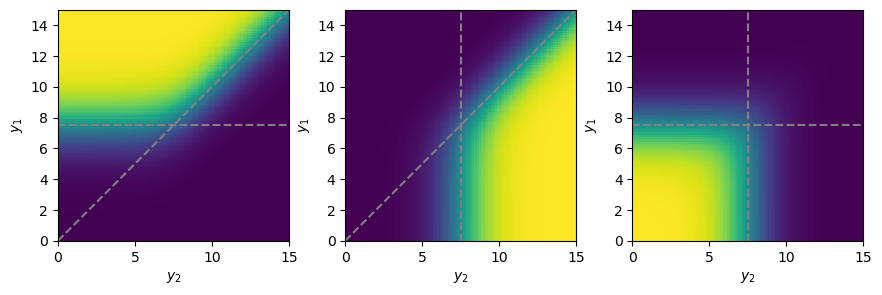

In [28]:
def plot_softmax(ylo, yhi, n=100):
    y_grid = np.linspace(ylo, yhi, n)
    y3 = 0.5 * (ylo + yhi)
    p_grid = np.array([softmax([y1, y2, y3]) for y1 in y_grid for y2 in y_grid]).reshape(n, n, 3)
    _, ax = plt.subplots(1, 3, figsize=(10.5, 3))
    for k in range(3):
        ax[k].imshow(p_grid[:, :, k], interpolation='none', origin='lower', extent=[ylo, yhi, ylo, yhi])
        ax[k].set_ylabel('$y_1$')
        ax[k].set_xlabel('$y_2$')
        if k != 0: ax[k].axvline(y3, c='gray', ls='--')
        if k != 1: ax[k].axhline(y3, c='gray', ls='--')
        if k != 2: ax[k].plot([ylo, yhi], [ylo, yhi], c='gray', ls='--')
        ax[k].grid(False)
    
plot_softmax(0, 15)

This is what we mean by "winner take all".  In the left plot, wherever $y_1$ is larger than $y_2$ and $y_3$ we see the softmax output for $p_1$ is high.  ($y_3$ is always set to 8 in this example.)  Similarly, in the middle plot, wherever $y_2$ is larger than $y_1$ or $y_3$, $p_2$ wins.  In the right plot, $p_3$ only wins when $y_1$ and $y_2$ are small.

The example above assumed output activations that can be large and positive, such as `relu` or `elu`. However, the strength of the *winner takes all* effect depends on how the outputs are scaled, and is relatively weak for output activations that saturate on both sides, such as `sigmoid` or `tanh`, which is why these are generally not used for classification outputs:

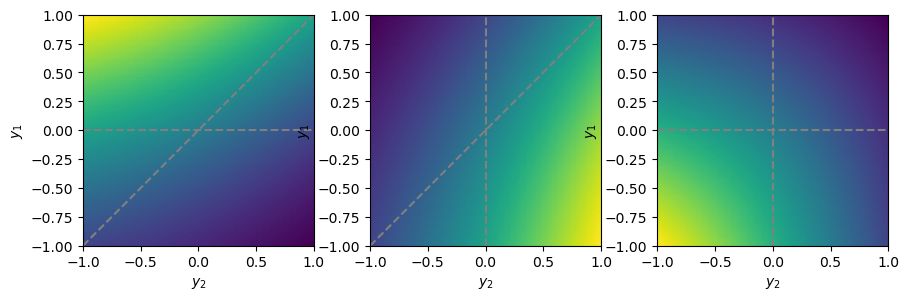

In [29]:
plot_softmax(-1, +1)

Note that we assume [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) of the vector target values $\mathbf{y}^{out}$, which is not very efficient (unless using sparse-optimized data structures) compared to a single integer target value $y^{train} = 0, 1, \ldots, C-1$. However, sklearn has a [convenient utility](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to convert integers to one-hot encoded vectors (use `sparse=True` to return vectors in an efficient [scipy sparse array](https://docs.scipy.org/doc/scipy/reference/sparse.html)).